# Image classification with CNN
Reference: https://medium.com/bitgrit-data-science-publication/building-an-image-classification-model-with-pytorch-from-scratch-f10452073212

In [1]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation
import os
import random
import torch # PyTorch package
from PIL import Image
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tqdm import tqdm

os.chdir("../")
random.seed(42)

### 1. Load and normalize data

In [2]:
# define classes
CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck',
]

In [3]:
# identify class (idx) from filename
def get_idx(fname):
    if "(" not in fname:
        return 0
    return int(fname.split("(")[1].split(")")[0]) - 1

In [4]:
# set transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# set training data type
train_data_type = {
    "REAL": 0.2, 
    "FAKE": 0.2
}
d_type_str = "REAL2+FAKE2"

# load training data
train_data = []
for d_type, r in train_data_type.items():
    train_dir = f"data/cifake/train/{d_type}"
    train_fnames = os.listdir(train_dir)
    train_fnames = random.sample(train_fnames, int(len(train_fnames) * r))
    for fname in tqdm(train_fnames):
        img = Image.open(f"{train_dir}/{fname}")
        train_data.append({"img": transform(img), "label": get_idx(fname)})
print(len(train_data))
print(train_data[0])

100%|██████████| 10000/10000 [00:02<00:00, 3925.35it/s]

20000
{'img': tensor([[[ 0.2784,  0.3020,  0.3569,  ..., -0.3255, -0.4275, -0.5373],
         [ 0.1765,  0.1216,  0.1059,  ..., -0.1843, -0.2314, -0.3020],
         [ 0.1765,  0.2157,  0.2784,  ..., -0.2000, -0.2941, -0.4039],
         ...,
         [ 0.5216,  0.5373,  0.5529,  ...,  0.3961,  0.2000, -0.0039],
         [ 0.4902,  0.5059,  0.5216,  ...,  0.3333,  0.2314,  0.0588],
         [ 0.4745,  0.4902,  0.5059,  ...,  0.4039,  0.4275,  0.2627]],

        [[ 0.4039,  0.4275,  0.4667,  ..., -0.1451, -0.2549, -0.3725],
         [ 0.3020,  0.2471,  0.2314,  ..., -0.0039, -0.0588, -0.1373],
         [ 0.3098,  0.3569,  0.4196,  ..., -0.0118, -0.1137, -0.2235],
         ...,
         [ 0.4902,  0.5059,  0.5216,  ...,  0.3647,  0.1686, -0.0353],
         [ 0.4824,  0.4980,  0.5137,  ...,  0.3255,  0.2235,  0.0510],
         [ 0.4667,  0.4824,  0.4980,  ...,  0.3961,  0.4196,  0.2549]],

        [[ 0.0353,  0.0431,  0.0824,  ..., -0.5686, -0.6157, -0.7098],
         [-0.0667, -0.1216, -0.

In [6]:
# set params
BATCH_SIZE = 40

# set up train dataloader
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
ex = next(iter(train_dataloader))
print(ex["img"].shape, ex["label"].shape)

torch.Size([40, 3, 32, 32]) torch.Size([40])


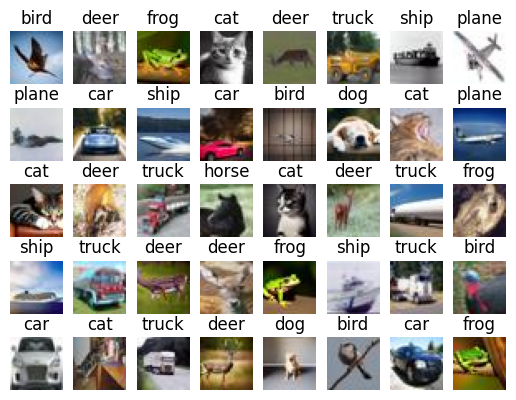

In [7]:
# display batch of data
fig = plt.figure()
for i, img in enumerate(ex["img"]):
    fig.add_subplot(5, 8, i+1)
    npimg = (img / 2 + 0.5).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(CLASSES[int(ex["label"][i])])
    plt.axis("off")

In [8]:
# load validation data
test_dir = f"data/cifake/test/REAL"
test_fnames = os.listdir(test_dir)
test_data = []
for fname in tqdm(test_fnames):
    img = Image.open(f"{test_dir}/{fname}")
    test_data.append({"img": transform(img), "label": get_idx(fname)})
print(test_data[0])

  7%|▋         | 704/10000 [00:00<00:02, 3374.67it/s]

100%|██████████| 10000/10000 [00:02<00:00, 3593.82it/s]

{'img': tensor([[[0.9608, 0.9686, 0.9843,  ..., 0.8980, 0.9216, 0.8902],
         [0.9686, 0.9686, 0.9922,  ..., 0.8588, 0.8902, 0.9451],
         [0.9843, 0.9843, 0.9922,  ..., 0.9137, 0.8980, 0.9686],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.9922, 0.9529, 0.9294],
         [0.9843, 1.0000, 0.9294,  ..., 1.0000, 0.9765, 0.9922],
         [1.0000, 1.0000, 0.9373,  ..., 0.9686, 0.9843, 1.0000]],

        [[0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 0.9843],
         [0.9922, 0.9922, 0.9843,  ..., 1.0000, 0.9843, 1.0000],
         [0.9843, 0.9843, 0.9843,  ..., 1.0000, 0.9843, 1.0000],
         ...,
         [0.9216, 0.9765, 0.9922,  ..., 1.0000, 0.9608, 0.9529],
         [0.9137, 0.9843, 0.8980,  ..., 0.9922, 0.9686, 1.0000],
         [0.9843, 0.9922, 0.9059,  ..., 0.9529, 0.9765, 0.9922]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9529],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.9686, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.

In [9]:
# set up test dataloader
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
ex = next(iter(test_dataloader))
print(ex["img"].shape, ex["label"].shape)

torch.Size([40, 3, 32, 32]) torch.Size([40])


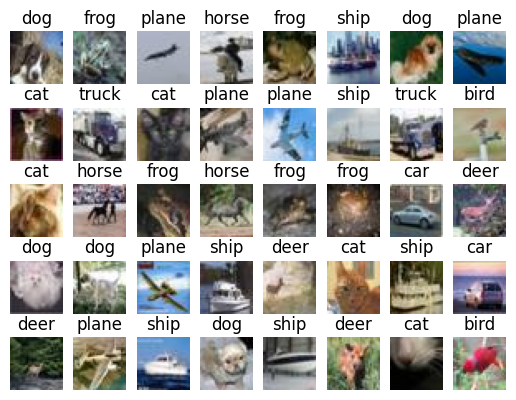

In [10]:
# display batch of data
fig = plt.figure()
for i, img in enumerate(ex["img"]):
    fig.add_subplot(5, 8, i+1)
    npimg = (img / 2 + 0.5).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(CLASSES[int(ex["label"][i])])
    plt.axis("off")

### 2. Define the CNN

In [11]:
class ImageClassifier(nn.Module):
    ''' Models a simple CNN image classifier'''
	
    def __init__(self):
        ''' initialize the network '''
        super(ImageClassifier, self).__init__()
	    # 3 input image channel, 6 output channels, 
	    # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 32, 5)
	    # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5) 
        self.fc1 = nn.Linear(64 * 5 * 5, 256) # 5x5 from image dimension
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ImageClassifier()
print(model)

ImageClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [12]:
# use gpu
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

### 3. Define a loss function and optimizer

In [13]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# oprimizer
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

### 4. Train the model

In [14]:
metrics = {}
for epoch in range(16):  # loop over the dataset multiple times
    
    print(f"Epoch {epoch + 1}:")
    
    model.train()
    train_loss, train_acc = 0, 0
    for data in train_dataloader:
        
        imgs = data["img"]
        labels = data["label"].long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # get statistics
        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, axis=1) == labels).float().sum().item()
        
    train_loss = round(train_loss / len(train_dataloader), 4)
    train_acc = round(train_acc / len(train_data), 4)
    print(f"Train loss = {train_loss}; acc = {train_acc}.")
    
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for data in test_dataloader:
            
            imgs = data["img"]
            labels = data["label"].long()
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
            test_acc += (torch.argmax(outputs, axis=1) == labels).float().sum().item()
    
    test_loss = round(test_loss / len(test_dataloader), 4)
    test_acc = round(test_acc / len(test_data), 4)
    print(f"Test loss = {test_loss}; acc = {test_acc}.")
    
    if epoch == 0 or test_loss < min([m[2] for m in metrics.values()]) or test_acc > max([m[3] for m in metrics.values()]):
        model_save_path = f"models/simple_CNN/{d_type_str}/checkpoint_{epoch:02}.pth"
        torch.save(model.state_dict(), model_save_path)
        print(f"Checkpoint saved at {model_save_path}.")
    
    print("\n")
    
    metrics[epoch] = (train_loss, train_acc, test_loss, test_acc)

Epoch 1:
Train loss = 1.5272; acc = 0.4398.
Test loss = 1.5347; acc = 0.4409.
Checkpoint saved at models/simple_CNN/REAL2+FAKE2/checkpoint_00.pth.


Epoch 2:
Train loss = 1.1444; acc = 0.5881.
Test loss = 1.3787; acc = 0.4998.
Checkpoint saved at models/simple_CNN/REAL2+FAKE2/checkpoint_01.pth.


Epoch 3:
Train loss = 0.9744; acc = 0.6523.
Test loss = 1.294; acc = 0.5359.
Checkpoint saved at models/simple_CNN/REAL2+FAKE2/checkpoint_02.pth.


Epoch 4:
Train loss = 0.8537; acc = 0.7001.
Test loss = 1.2529; acc = 0.5537.
Checkpoint saved at models/simple_CNN/REAL2+FAKE2/checkpoint_03.pth.


Epoch 5:
Train loss = 0.7606; acc = 0.7335.
Test loss = 1.2219; acc = 0.5692.
Checkpoint saved at models/simple_CNN/REAL2+FAKE2/checkpoint_04.pth.


Epoch 6:
Train loss = 0.667; acc = 0.7679.
Test loss = 1.1468; acc = 0.6028.
Checkpoint saved at models/simple_CNN/REAL2+FAKE2/checkpoint_05.pth.


Epoch 7:
Train loss = 0.5797; acc = 0.7984.
Test loss = 1.2216; acc = 0.5915.


Epoch 8:
Train loss = 0.5052

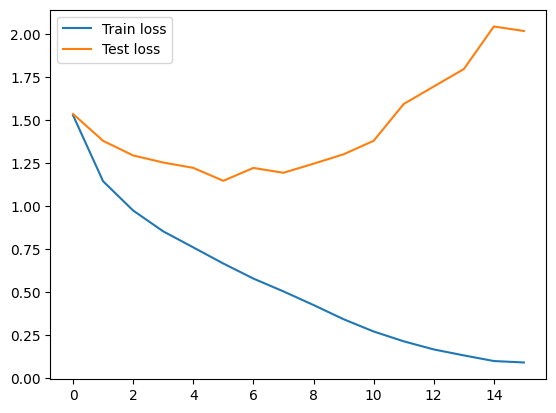

In [15]:
plt.plot([x[0] for x in metrics.values()], label="Train loss")
plt.plot([x[2] for x in metrics.values()], label="Test loss")
plt.legend()